## Intro

Having trained several models trained on several different data distributions, let's plot their performace throughout the manifold, and compare to the ground truth function.

This notebook examines logspace_broad, which aims to capture all of the features of logspace behavior.

Let's load the python modules and the model, first.

In [1]:
from utils import *
from datafile import *
from betaVAE import *

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

fname = 'logspace_broad'

beta, latent, datasize, learning_rate, epochs, muW, muB, stdW, stdB = get_params(fname)
print([beta, latent, datasize, learning_rate, epochs, muW, muB, stdW, stdB])
ln=True

L = get_loss(fname)

model = get_model(fname)

beta,latent,datasize,learning_rate,epochs,muW,muB,stdW,stdB,ln

[0.01, 5, 2048, 0.0001, 50000, 0.0, -0.6931471805599453, 2.0, 2.0]


## Learning

First, let's take a look at the learning curve, to make sure that the net seems to have plateaued. To avoid wasting space, the first several losses won't be visible.

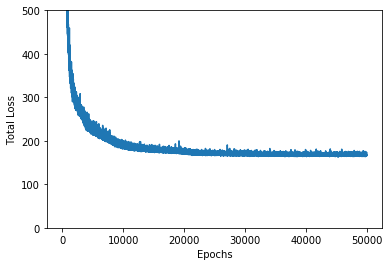

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

fig = plt.figure()
plt.plot(range(1, len(L)+1), L)
plt.ylim([0, 500])
plt.xlabel("Epochs")
plt.ylabel("Total Loss")

fig

It appears that the overall loss has plateaued around

In [3]:
print(L[-10:])

[169.1085662841797, 165.51979064941406, 168.0488739013672, 167.85809326171875, 165.54107666015625, 166.7396697998047, 167.15948486328125, 172.1241912841797, 166.1070556640625, 166.94992065429688]


## Behavior on Training Data; Metrics

Now that we see that the network is fully trained, let's look at several metrics of its performance on the domain where it was trained.

Let's take a look at the data itself, first.

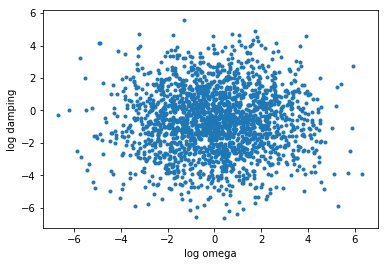

In [5]:
data, groundTruth = log_datagen(muW, muB, stdW, stdB, datasize)

fig = plt.figure()
plt.scatter(data[:, 0], data[:, 1], marker='.')
plt.xlabel("log omega")
plt.ylabel("log damping")
#plt.ylim([np.log(0.01), np.log(1)])
#plt.xlim([np.log(0.2), np.log(5.0)])

fig

Now, let's compute the network's output on this data, and then compute some metrics.

In [7]:
d = torch.FloatTensor(data).cuda()

o, mu, _ = model(d)

output = o.cpu().detach().numpy()
means = mu.cpu().detach().numpy()

In [8]:
errors = output - groundTruth

phaseE = errors[:, 0]
ampE = errors[:, 1]

print(errors)

[[-0.01635399 -0.01325025]
 [-0.01770674 -0.04132858]
 [-0.00936712  0.01219774]
 ...
 [ 0.0480051  -0.00758179]
 [-0.01877971 -0.00787633]
 [-0.03611408 -0.03039535]]


In [9]:
phases = groundTruth[:, 0]
amps = groundTruth[:, 1]

prange = max(phases) - min(phases)
arange = max(amps) - min(amps)

# I average the squared errors because the network is trained to minimize error**2, 
# but I compute the square root so we can compare this to the ranges.
typicalpe = np.sqrt(np.mean(phaseE**2))
typicalae = np.sqrt(np.mean(ampE**2))

print("Typical Phase Error")
print(typicalpe)
print("Typical Amp Error")
print(typicalae)

print("Typical phase error / phase range")
print(typicalpe/prange)
print("Typical amp error / amp range")
print(typicalae/arange)

Typical Phase Error
0.025929884440004682
Typical Amp Error
0.021560132348826356
Typical phase error / phase range
0.008254086712277155
Typical amp error / amp range
0.0013658773429076486


So far, so good. We see the typical error on the data distribution the network was trained on. Later on, we'll also examine how the latent space was used using "means," but for now, let's try to fully understand how well this network understands the underlying function.

## Plots of The Function

### Behavior Near Training Distribution

To begin with, we will plot the groundTruth and the network approximation within the domain where it was trained ($mu \pm 2\sigma $), as well as a distribution of the errors.

In [10]:
#Make the data

wmin = muW - 2*stdW
wmax = muW + 2*stdW
wstep = (wmax - wmin)/100

bmin = muB - 2*stdB
bmax = muB + 2*stdB
bstep = (bmax - bmin)/100

w = np.arange(wmin, wmax, wstep)
b = np.arange(bmin, bmax, bstep)

W, B = np.meshgrid(w, b)

print(W.shape)

(100, 100)


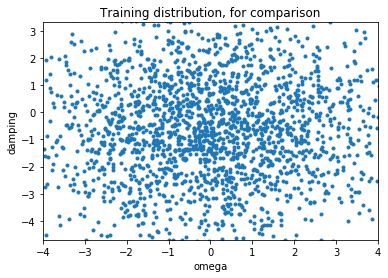

In [11]:
# Plot some training data

fig = plt.figure()
plt.scatter(data[:, 0], data[:, 1], marker='.')
plt.xlim([wmin, wmax])
plt.ylim([bmin, bmax])
plt.title("Training distribution, for comparison")
plt.xlabel("omega")
plt.ylabel("damping")

fig

In [12]:
# Compute the ground truth

Phi = phi(np.exp(W), np.exp(B))
A = np.log(amplitude(np.exp(W), np.exp(B)))

In [13]:
# Compute network output

gridpoints = torch.FloatTensor(np.concatenate((W.reshape(10000, 1), B.reshape(10000, 1)), axis=1)).cuda()

output, _, _ = model(gridpoints)

npo = output.cpu().detach().numpy()

modelPhi = npo[:, 0].reshape(100, 100)
modelA = npo[:, 1].reshape(100, 100)

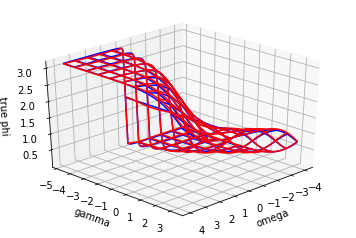

In [14]:
# Plot Phi, true and modeled

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_wireframe(W, B, Phi, rstride=10, cstride=10, color="blue")
surf = ax.plot_wireframe(W, B, modelPhi, rstride=10, cstride=10, color="red")
ax.view_init(30, 45)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("true phi")


fig

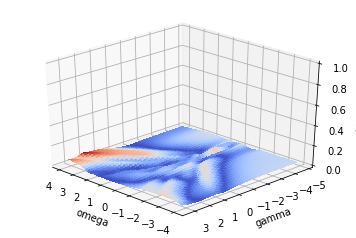

In [15]:
# Plot the L2 error

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(W, B, np.sqrt((modelPhi - Phi)**2), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("phi error")
ax.set_zlim([0, 1])

fig

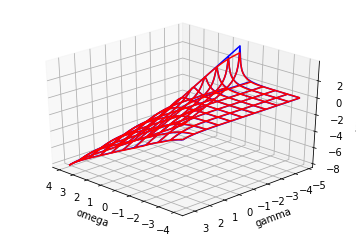

In [17]:
# Plot A

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_wireframe(W, B, A, rstride=10, cstride=10, color="blue")
surf = ax.plot_wireframe(W, B, modelA, rstride=10, cstride=10, color="red")
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("true A")
#ax.set_zlim(0, 1)

fig

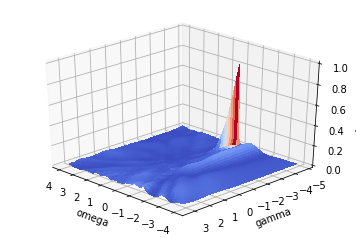

In [18]:
# Plot the L2 error

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(W, B, np.sqrt((modelA - A)**2), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("A error")
ax.set_zlim([0, 1])

fig

### Behavior away from the training distribution

Alright. Now how does the model perform well outside of its original domain?

Specifically for this model, we are in a slightly difficult position because the training area is much larger than the range of values we normally care about, but we can test for artefacts by simply increasing the window size artificially.

In [21]:
# Make the data

wmin = muW - 6*stdW
wmax = muW + 6*stdW
wstep = (wmax - wmin)/100

bmin = muB - 6*stdB
bmax = muB + 6*stdB
bstep = (bmax - bmin)/100

w = np.arange(wmin, wmax, wstep)
b = np.arange(bmin, bmax, bstep)

W, B = np.meshgrid(w, b)

print(W.shape)

(100, 100)


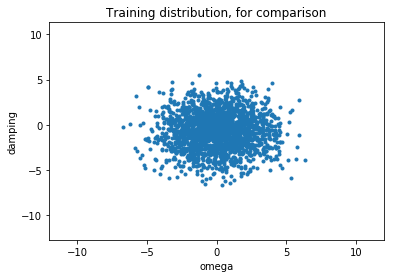

In [22]:
# Plot some training data

fig = plt.figure()
plt.scatter(data[:, 0], data[:, 1], marker='.')
plt.xlim([wmin, wmax])
plt.ylim([bmin, bmax])
plt.title("Training distribution, for comparison")
plt.xlabel("omega")
plt.ylabel("damping")

fig

In [23]:
# Compute the ground truth

Phi = phi(np.exp(W), np.exp(B))
A = np.log(amplitude(np.exp(W), np.exp(B)))

In [24]:
# Compute network output

gridpoints = torch.FloatTensor(np.concatenate((W.reshape(10000, 1), B.reshape(10000, 1)), axis=1)).cuda()

output, _, _ = model(gridpoints)

npo = output.cpu().detach().numpy()

modelPhi = npo[:, 0].reshape(100, 100)
modelA = npo[:, 1].reshape(100, 100)

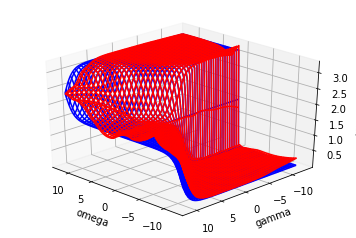

In [25]:
# Plot Phi, true and modeled

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_wireframe(W, B, Phi, color="blue")
surf = ax.plot_wireframe(W, B, modelPhi, color="red")
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("true phi")

fig

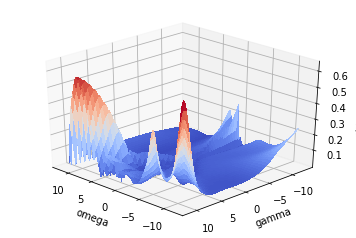

In [26]:
# Plot the L2 error

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(W, B, np.sqrt((modelPhi - Phi)**2), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("phi error")

fig

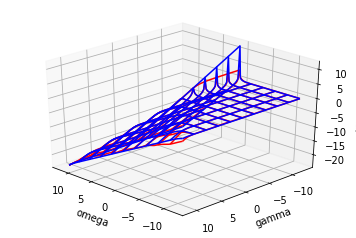

In [27]:
# Plot Ground Truth A

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_wireframe(W, B, A, rstride=10, cstride=10, color="blue")
surf = ax.plot_wireframe(W, B, modelA, rstride=10, cstride=10, color="red")
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("true A")
#ax.set_zlim([0, 5])

fig

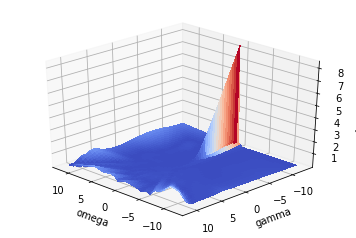

In [28]:
# Plot the L2 error

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(W, B, np.sqrt((modelA - A)**2), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("A error")
#ax.set_zlim([0, 5])

fig

Now that we are looking at the extrapolation potential of the system, let's take a look at the extremes.

In [29]:
print("Max predicted phase")
print(max(modelPhi.reshape((10000,))))
print("Min predicted phase")
print(min(modelPhi.reshape((10000,))))
print("Max predicted amplitude")
print(max(modelA.reshape((10000,))))
print("Min predicted amplitude")
print(min(modelA.reshape((10000,))))

print("\n\n")

print("Max true phase")
print(max(Phi.reshape((10000,))))
print("Min true phase")
print(min(Phi.reshape((10000,))))
print("Max true amplitude")
print(max(A.reshape((10000,))))
print("Min true amplitude")
print(min(A.reshape((10000,))))

Max predicted phase
3.2855215
Min predicted phase
0.012266191
Max predicted amplitude
3.6257117
Min predicted amplitude
-23.915466



Max true phase
3.1415926535418017
Min true phase
3.775134544421614e-11
Max true amplitude
11.99999999999999
Min true amplitude
-23.866573590249505


## Latent Space

Let's now look at the latent dimensions. Let's first see which are used at all during validation.

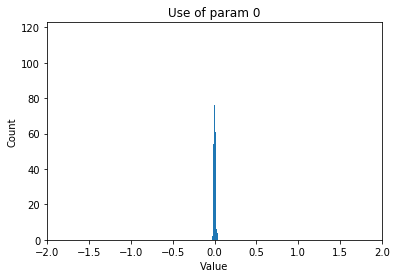

In [30]:
# Param 0 

fig = plt.figure()
plt.hist(means[:, 0], 100)
plt.xlim([-2, 2])
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Use of param 0")
fig

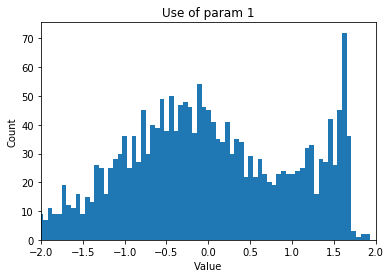

In [31]:
# Param 0 

fig = plt.figure()
plt.hist(means[:, 1], 100)
plt.xlim([-2, 2])
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Use of param 1")
fig

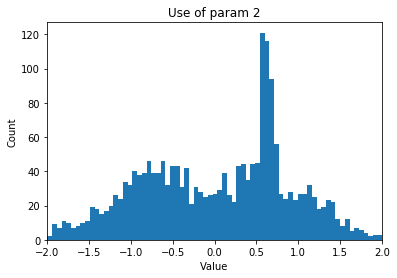

In [32]:
# Param 2

fig = plt.figure()
plt.hist(means[:, 2], 100)
plt.xlim([-2, 2])
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Use of param 2")
fig

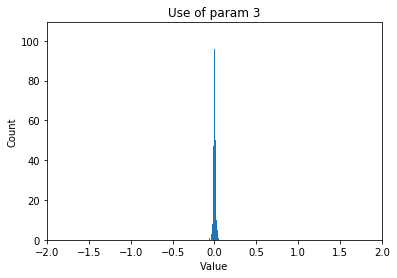

In [33]:
# Param 3

fig = plt.figure()
plt.hist(means[:, 3], 100)
plt.xlim([-2, 2])
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Use of param 3")
fig

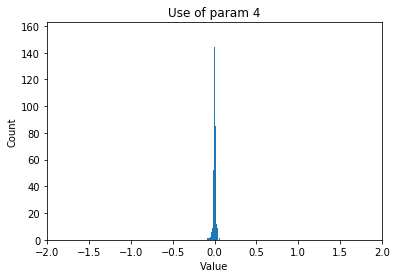

In [34]:
# Param 4

fig = plt.figure()
plt.hist(means[:, 4], 100)
plt.xlim([-2, 2])
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Use of param 4")
fig

It seems that, during evaluation, only parameters $1$ and $2$ are used - even if it seems like the distribution is not quite a univariate normal.

Let's plot their dependence on $\omega$ and $\gamma$ within the training distribution.

In [35]:
#Make the data

wmin = muW - 2*stdW
wmax = muW + 2*stdW
wstep = (wmax - wmin)/100

bmin = muB - 2*stdB
bmax = muB + 2*stdB
bstep = (bmax - bmin)/100

w = np.arange(wmin, wmax, wstep)
b = np.arange(bmin, bmax, bstep)

W, B = np.meshgrid(w, b)

print(W.shape)

(100, 100)


In [38]:
# Compute param values

gridpoints = torch.FloatTensor(np.concatenate((W.reshape(10000, 1), B.reshape(10000, 1)), axis=1)).cuda()

output, params, _ = model(gridpoints)

npm = params.cpu().detach().numpy()
npo = output.cpu().detach().numpy()

param1 = npm[:, 1].reshape(100, 100)
param2 = npm[:, 2].reshape(100, 100)

modelPhi = npo[:, 0].reshape(100, 100)
modelA = npo[:, 1].reshape(100, 100)

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


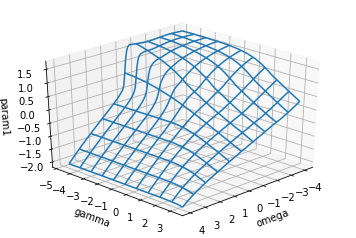

In [42]:
# Plot param 1

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_wireframe(W, B, param1, rstride=10, cstride=10)
ax.view_init(30, 45)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("param1")

fig

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


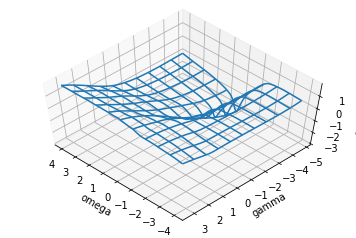

In [41]:
# Plot param 2

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_wireframe(W, B, param2, rstride=10, cstride=10)
ax.view_init(60, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("param2")

fig

In [43]:
# Compute ground truth

Phi = phi(np.exp(W), np.exp(B))
A = np.log(amplitude(np.exp(W), np.exp(B)))

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


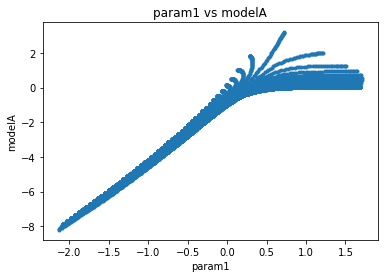

In [46]:
# Compare modelA and param1

fig = plt.figure()
plt.scatter(param1, modelA, marker='.')
plt.title("param1 vs modelA")
plt.xlabel("param1")
plt.ylabel("modelA")
fig

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


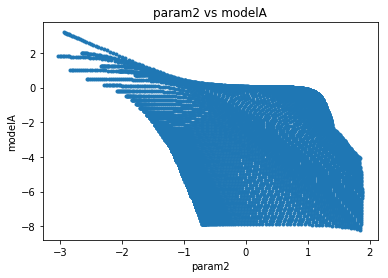

In [45]:
# Compare modelA and param2

fig = plt.figure()
plt.scatter(param2, modelA, marker='.')
plt.title("param2 vs modelA")
plt.xlabel("param2")
plt.ylabel("modelA")
fig

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


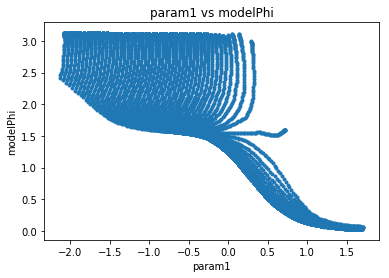

In [47]:
# Compare modelPhi and param1

fig = plt.figure()
plt.scatter(param1, modelPhi, marker='.')
plt.title("param1 vs modelPhi")
plt.xlabel("param1")
plt.ylabel("modelPhi")
fig

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


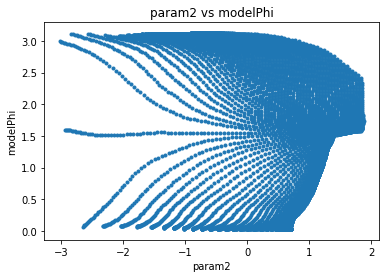

In [48]:
# Compare modelPhi and param2

fig = plt.figure()
plt.scatter(param2, modelPhi, marker='.')
plt.title("param2 vs modelPhi")
plt.xlabel("param2")
plt.ylabel("modelPhi")
fig

## Concluding Thoughts

This network performed very admirably, even on extrapolation. Only boring_patch was more straightforward. High frequency artefacts were certainly present, however, though they didn't grow quite as rapidly during extrapolation (possibly because the steep vertical drop had to be matched over a longer distance). In amplitude, the only portion with very poor extrapolation ws the "crease" (the ground truth rises linearly as $\log \gamma \rightarrow - \infty$, while the model plateaues) but this is an admittedly difficult feature to match.

Since this network didn't have to work with very large errors on any part of its domain, it leared to use exactly two of its latent features, as expected for a transofrmation with this dimensionality. The correlation between the latent space and output is less transparent here (except $A$ and param1 on some of the domain), however, and while both parameters seem to mimic something about the true functions - either a crease or a steep drop around $\omega = 1$ and small $\log \gamma$ - the two could hardly be said to be "natural" transformations of the underlying space.

In short using log coordinates helps the network avoid very steep pitfalls, but is still suffers from high-frequency features in extrapolation, and has a latent space that is hardly "natural." Let's see how the other logspace models fared.